In [1]:
from SliceNet import SliceNet
from netUtils import getSingleExample
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math

import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
TF_CPP_MIN_LOG_LEVEL=2

%load_ext autoreload
%autoreload 2

W0507 01:13:23.278324 140033714849536 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


1.13.1


Using TensorFlow backend.


importing hub
Instructions for updating:
Colocations handled automatically by placer.


W0507 01:14:13.885460 140033714849536 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [38]:
# Choose whether to use the base network or the network with self-attention
attention = True

best_base_wiki = '/home/bmmidei/SliceCast/models/04_20_2019_2300_final.h5'
best_base_podcast = '/home/bmmidei/SliceCast/models/04_26_2019_1000_podcast.h5'
best_attn_wiki = '/home/bmmidei/SliceCast/models/05_03_2019_0800_attn.h5'
best_attn_podcast = '/home/bmmidei/SliceCast/models/05_02_2019_2200_attn_podcast.h5'

if attention:
    weights_wiki = best_attn_wiki
    weights_podcast = best_attn_podcast
else:
    weights_wiki = best_base_wiki
    weights_podcast = best_base_podcast


net = SliceNet(classification=True,
               class_weights=[1.0,10,0.2],
               attention=attention)


## Sample predictions on unseen wiki articles

In [39]:
dataPath = Path('/home/bmmidei/SliceCast/data/dev/hdf5')
files = [str(x) for x in dataPath.glob('**/*') if x.suffix=='.hdf5']

mask = random.sample(range(0,len(files)), 1)

# randomly select a file to test
test_file = [x for (i,x) in enumerate(files) if i in mask][0]

In [45]:
k = 4
num_samples = 20

preds, labels, pk = net.predict(test_file=test_file,
                                num_samples=num_samples,
                                weights_path=weights_wiki,
                                k=k)
print('Average PK score with k={} on {} examples is: {:0.3f}'.format(k, num_samples, pk))

Starting Testing
Loaded weights from disk


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f570411f390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Average PK score with k=4 on 20 examples is: 0.271


In [46]:
np.set_printoptions(suppress=True)

preds = np.argmax(preds, axis=2)
labels = np.argmax(labels, axis=2)

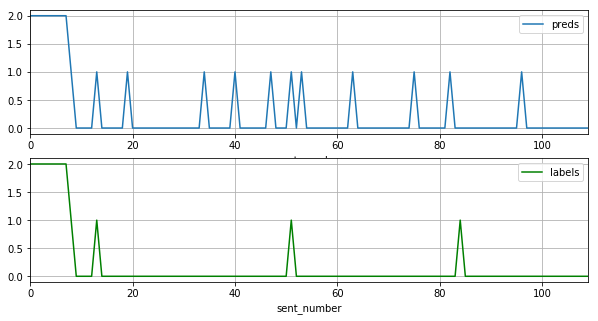

In [52]:
# Choose the document you want to examine
# You can keep running this cell with different indices to visualize different
# documents within this batch of testing
idx = 5

df = pd.DataFrame()
df['preds'] = preds[idx,:]
df['labels'] = labels[idx,:]
df['sent_number'] = df.index

fig, axes = plt.subplots(nrows=2, ncols=1)

df.plot(x='sent_number', y='preds', figsize=(10,5), grid=True, ax=axes[0])
df.plot(x='sent_number', y='labels', figsize=(10,5), grid=True, ax=axes[1], color='green')

## Sample predictions on unseen podcast data

In [53]:
test_file = '/home/bmmidei/SliceCast/data/podcasts/hdf5/batch0_0.hdf5'
k = 22
num_samples = 8
preds, labels, pk = net.predict(test_file=test_file,
                    num_samples=num_samples,
                    weights_path=weights_podcast,
                    k=k)

print('Average PK score with k={} on {} examples is: {:0.3f}'.format(k, num_samples, pk))

Starting Testing
Loaded weights from disk


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f56f5a7fa58>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Average PK score with k=22 on 8 examples is: 0.248


In [54]:
np.set_printoptions(suppress=True)

preds = np.argmax(preds, axis=2)
labels = np.argmax(labels, axis=2)

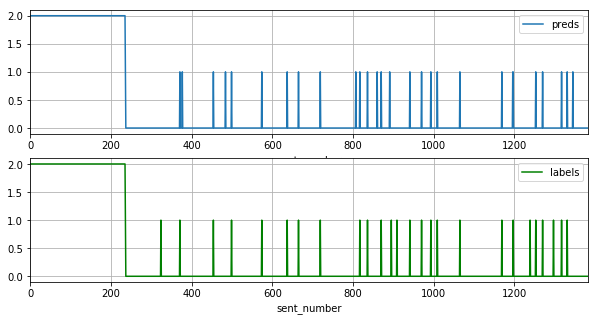

In [62]:
# Choose the document you want to examine
idx = 6

df = pd.DataFrame()
df['preds'] = preds[idx,:]
df['labels'] = labels[idx,:]
df['sent_number'] = df.index

fig, axes = plt.subplots(nrows=2, ncols=1)

df.plot(x='sent_number', y='preds', figsize=(10,5), grid=True, ax=axes[0])
df.plot(x='sent_number', y='labels', figsize=(10,5), grid=True, ax=axes[1], color='green')

## Predictions on a single text file

In [41]:
text_file = '/home/bmmidei/SliceCast/data/podcasts/with_timestamps/joe1254.txt'
is_labeled = True
#weights_path = '/home/bmmidei/SliceCast/models/04_20_2019_2300_final.h5' # wiki trained
weights_path = '/home/bmmidei/SliceCast/models/04_26_2019_1000_podcast.h5' # transfer learning

sents, labels = getSingleExample(fname=text_file, is_labeled=is_labeled)
sents = np.expand_dims(sents, axis=0)
print(sents.shape)
print(len(labels))
preds = net.singlePredict(sents, weights_path=weights_path)
print(preds.shape)

(1, 1009)
1009
Starting Testing
Loaded weights from disk


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fbcd5f8f1d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


(1, 1009, 3)


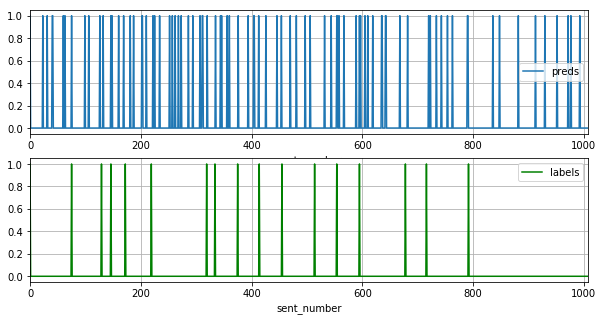

In [31]:
# Place data into a pandas dataframe for analysis
df = pd.DataFrame()

preds = np.argmax(np.squeeze(preds), axis=-1)
df['raw_sentences'] = sents[0]
if is_labeled:
    df['labels'] = labels
df['preds'] = preds
df['sent_number'] = df.index

fig, axes = plt.subplots(nrows=2, ncols=1)

df.plot(x='sent_number', y='preds', figsize=(10,5), grid=True, ax=axes[0])
df.plot(x='sent_number', y='labels', figsize=(10,5), grid=True, ax=axes[1], color='green')

In [27]:
df.head(50)

,raw_sentences,labels,preds,sent_number
0,5 4 3 2 1 is it hanging up on me?,1,1,0
1,"Well, I've live.",0,0,1
2,Dr. Phil.,0,0,2
3,"Well, I've someone's calling you it's going on...",0,0,3
4,I was trying to find now there's a little shit...,0,0,4
5,How how did this catch me outside girl.,0,0,5
6,How did this happen at all the all the differe...,0,0,6
7,"I know I mean, it's my moment of infamy.",0,0,7
8,Seriously.,0,0,8
9,This girl comes on with her mother and her mot...,0,0,9


In [42]:
print(preds.shape)

(1, 1009, 3)


In [22]:
print(sents.shape)

(1, 1009)


In [50]:
from postprocess import getSummaries, getTimeStamps
#preds = np.argmax(np.squeeze(preds), axis=-1)

In [86]:
keywords = getSummaries(sents[0], preds)
print(len(keywords))

15


In [90]:
stamps = getTimeStamps(sents[0], '/home/bmmidei/SliceCast/data/podcasts/with_timestamps/joe1254.json', preds)

In [91]:
stamps


[0,
 186,
 335,
 1031,
 1265,
 2072,
 2271,
 2281,
 2845,
 2849,
 3188,
 4036,
 4234,
 4527,
 5702]

In [115]:
import math
seconds = [x%60 for x in stamps]
minutes = [math.floor(x/60) for x in stamps]
for i, (x, y)in enumerate(zip(minutes, seconds)):
    print("{}:{}".format(x, y), end="")
    print([x[0] for x in keywords[i]])

0:0['mother', 'night', 'girl']
3:6['people', 'payoff', 'weird thing']
5:35['somebody', 'incremental changes', 'important thing']
17:11['people', 'depression', 'something']
21:5['people', 'medication today', 'opioids']
34:32['shoulder surgery', 'organic pain', 'doctor']
37:51['ton', 'loot', 'sure']
38:1['people', 'thing', 'kinds']
47:25['lot', 'deception detection', 'big news stories']
47:29['people', 'somebody', 'guy']
53:8['lot', 'people', 'guy']
67:16['guy', 'time', 'fight']
70:34['nicest guy', 'time', 'custom model']
75:27['something', 'good', 'things']
95:2['money', 'shampoo', 'thanks']
